In [1]:
from nsopy import UniversalPGM as UPGM
from nsopy import UniversalDGM as UDGM
from nsopy import UniversalFGM as UFGM
from nsopy import SubgradientMethod as SGM
from nsopy.loggers import GenericDualMethodLogger

%cd ..

C:\Users\vujanicr\PycharmProjects\smpspy_base


In [2]:
from smpspy.oracles import TwoStage_SMPS_InnerProblem

Generate inner problem to inerface with solvers

In [5]:
ip = TwoStage_SMPS_InnerProblem('./smpspy/benchmark_problems/2_caroe_schultz/caroe_schultz_100')

Parsing nominal model information from ./smpspy/benchmark_problems/2_caroe_schultz/caroe_schultz_100.cor and .tim ...
Parsing stochastic information from ./smpspy/benchmark_problems/2_caroe_schultz/caroe_schultz_100.sto ...
Stochastic model is of type SCENARIOS DISCRETE


Confirm that the det. equivalent solves with objective 62.29 (as in paper)

In [6]:
deterministic_equivalent = ip.stoch_model.generate_deterministic_equivalent()
deterministic_equivalent.optimize()

Generating deterministic equivalent for the model ...
Optimize a model with 201 rows, 402 columns and 1002 nonzeros
Variable types: 0 continuous, 402 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e-01, 4e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [5e+00, 2e+01]
Found heuristic solution: objective -44.29
Presolve removed 6 rows and 11 columns
Presolve time: 0.05s
Presolved: 195 rows, 391 columns, 953 nonzeros
Found heuristic solution: objective -48.1000000
Variable types: 0 continuous, 391 integer (389 binary)

Root relaxation: objective -6.483712e+01, 245 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -64.83712    0  137  -48.10000  -64.83712  34.8%     -    0s
H    0     0                     -59.8200000  -64.83712  8.39%     -    0s
     0     0  -62.10909    0  127  -59.820

In [7]:
UGM_EPS = 1.0
SGM_S_0 = 1.0

upgm = UPGM(ip.oracle, ip.projection_function, dimension=ip.dimension, epsilon=UGM_EPS, averaging=True)
udgm = UDGM(ip.oracle, ip.projection_function, dimension=ip.dimension, epsilon=UGM_EPS, averaging=True)
ufgm = UFGM(ip.oracle, ip.projection_function, dimension=ip.dimension, epsilon=UGM_EPS, averaging=True)
sgm_const = SGM(ip.oracle, ip.projection_function, dimension=ip.dimension, stepsize_0=1.0, stepsize_rule='constant') 

upgm_logger = GenericDualMethodLogger(upgm)
udgm_logger = GenericDualMethodLogger(udgm)
ufgm_logger = GenericDualMethodLogger(ufgm)
sgm_const_logger = GenericDualMethodLogger(sgm_const)

In [ ]:
for i in range(50):
    sgm_const.dual_step()
#     upgm.dual_step()
#     udgm.dual_step()
#     ufgm.dual_step()

## Constants of the bound:

* $p^{\mathrm{max}}_{\mathrm{UB}} = 0$
* $\rho = 2.5$
* $d_{\mathrm{LB}} = d(0) = -70.57851239671679$

Imply that $\| \lambda^\star \|_2 \leq 28.23$. In our experiments we find that $\| \lambda_{k=\mathrm{end}} \|_2 = 0.52$, bound verified.

In [116]:
import gurobipy as gb
import numpy as np

In [108]:
# find p_UB^max
deterministic_equivalent.setObjective(0, sense=gb.GRB.MINIMIZE)
deterministic_equivalent.optimize()

Optimize a model with 243 rows, 486 columns and 1212 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 6e+00]
  Objective range [0e+00, 0e+00]
  Bounds range    [1e+00, 5e+00]
  RHS range       [5e+00, 2e+01]
Found heuristic solution: objective 0
Presolve removed 243 rows and 486 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0%


In [117]:
# find all the constants
_, d_0, _= ip.oracle(lambda_k=np.zeros(ip.dimension))
# print(d_0)
RHO = 2.5
R_D = (0-d_0)/RHO
# print(R_D)
D_X = np.linalg.norm([5,5])

In [118]:
analytic_bound_ugm = [UGM_EPS/2.0 + (4*(D_X*R_D)**2)/(UGM_EPS*(k+1)) for k in range(len(sgm_const_logger.d_k_iterates))]
analytic_bound_sgm_const = [(R_D+ D_X**2*(k+1)*SGM_S_0)/(2*(k+1)*SGM_S_0) for k in range(len(sgm_const_logger.d_k_iterates))]
# analytic_bound_sgm_1k = [(R_D+ D_X**2*k*SGM_S_0)/(2*k*SGM_S_0) for k in range(len(upgm_logger.d_k_iterates))]

Plot it

In [119]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [120]:
# Compute d^best_k for subgradient
sgm_const_logger.d_k_best = [sgm_const_logger.d_k_iterates[1],]
for k, d_k in enumerate(sgm_const_logger.d_k_iterates[2:]):
    sgm_const_logger.d_k_best.append(max(sgm_const_logger.d_k_best[-1], d_k))

<IPython.core.display.Javascript object>


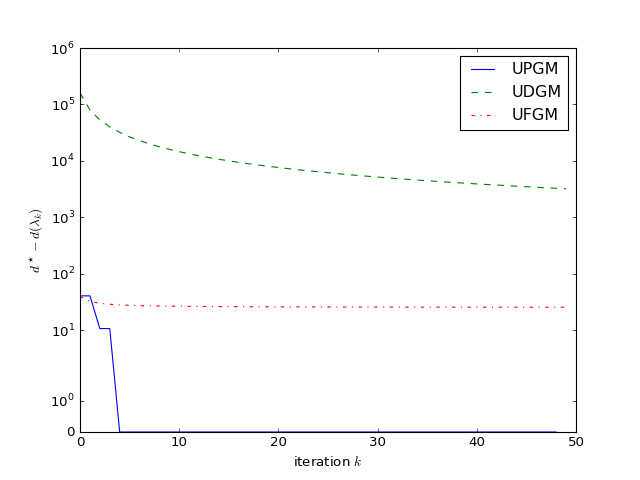

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(method_logger.d_k_iterates, marker='o', color='black', ls='')
# ax.plot([max(upgm_logger.d_k_iterates)-d_k for d_k in upgm_logger.d_k_iterates])
# ax.plot([max(udgm_logger.d_k_iterates)-d_k for d_k in udgm_logger.d_k_iterates])
# ax.plot([max(ufgm_logger.d_k_iterates)-d_k for d_k in ufgm_logger.d_k_iterates])
ax.plot([max(sgm_const_logger.d_k_iterates[1:])-d_k for d_k in sgm_const_logger.d_k_best])
ax.plot(analytic_bound_ugm, '--')
ax.plot(analytic_bound_sgm_const, '-.')

ax.set_yscale('symlog')
ax.set_yscale('symlog')
ax.set_ylabel('$d^\star - d(\lambda_k)$')
ax.set_xlabel('iteration $k$')
ax.legend(['UPGM','UDGM','UFGM','Analytic Bound'])

In [76]:
analytic_bound_sgm_const

[]